In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
file_path = r''

In [ ]:
df = pd.read_csv(f"{file_path}", index_col="XXX", parse_dates=True)
df.index.freq = 'W-MON'  # Đặt tần suất cho index để tránh cảnh báo ValueWarning
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [ ]:
# Change the name of the time series variable to y
df = df.rename(columns={'XXXX': 'y'})
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Freq: W-MON
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   y                        261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [5]:
df["y"] = df["y"].str.replace(",","")
df["y"] = df["y"].astype(int)

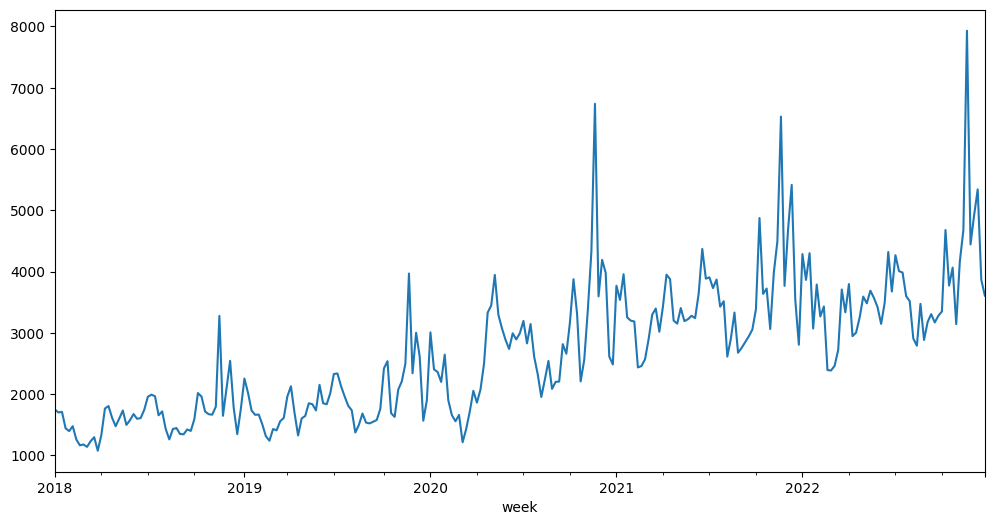

In [6]:
# Time series plot
df["y"].plot(figsize=(12, 6));

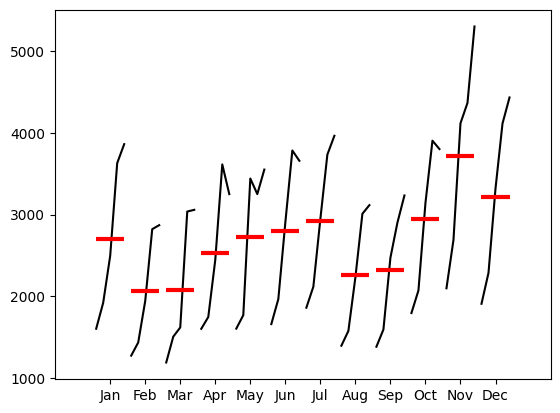

In [7]:
month_plot(df['y'].resample('ME').mean());

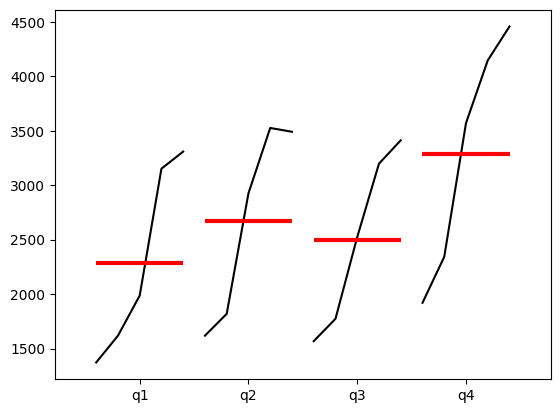

In [8]:
quarter_plot(df['y'].resample('QE').mean());

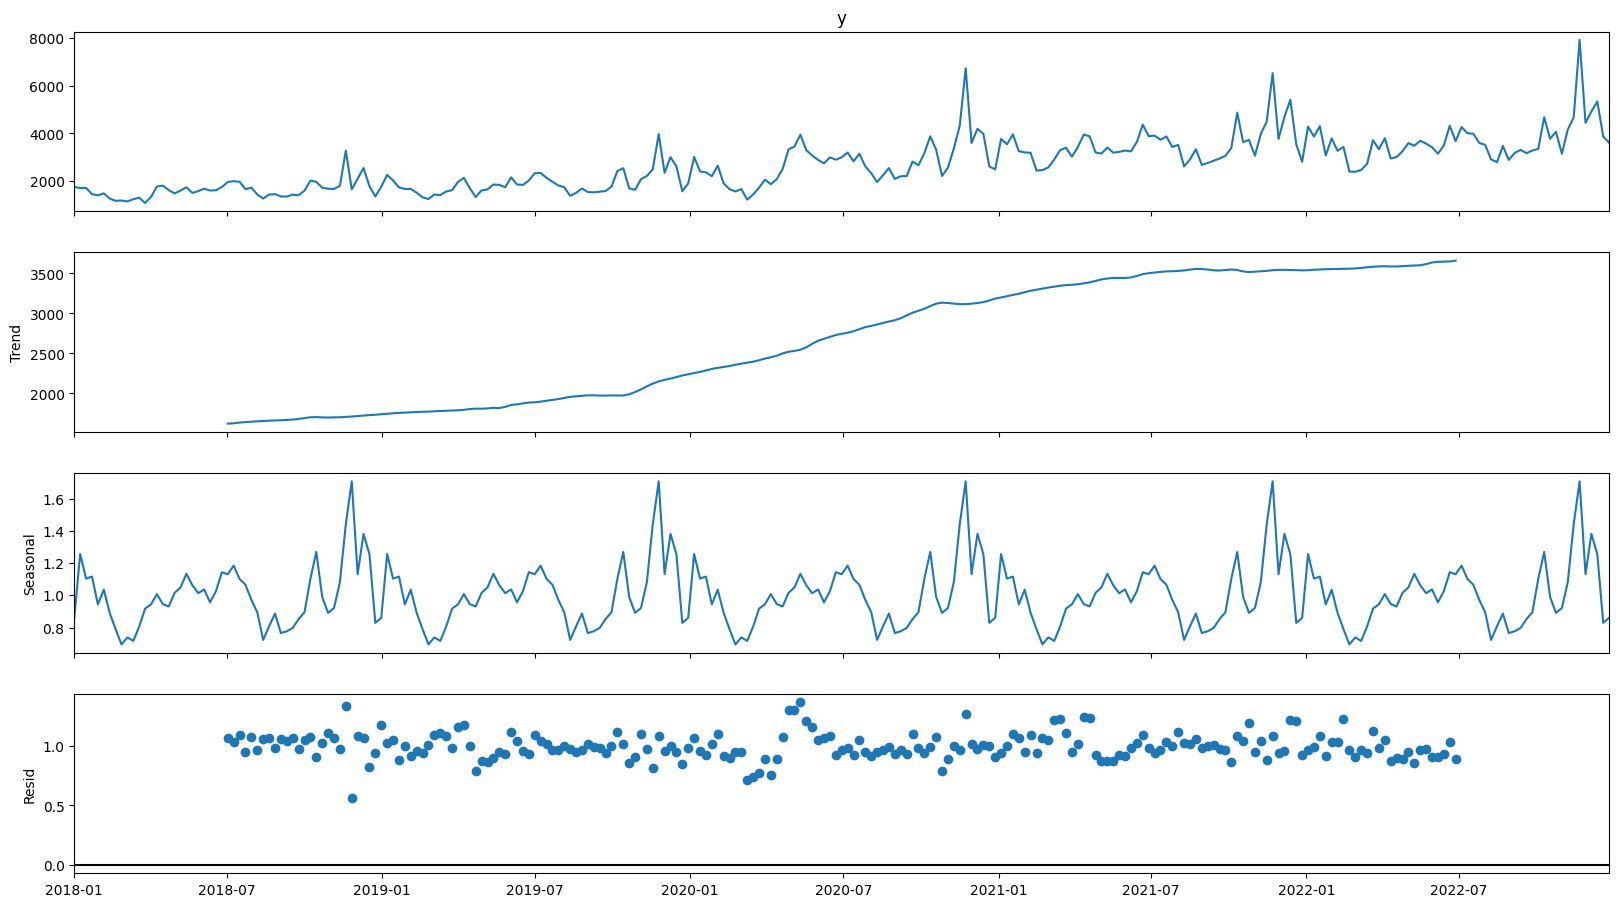

In [9]:
# Seasonal decomposition for df["Adj Close"]
decomposition = seasonal_decompose(df["y"], model='multiplicative',period=52)
fig = decomposition.plot()
fig.set_size_inches(18,10)
plt.show()

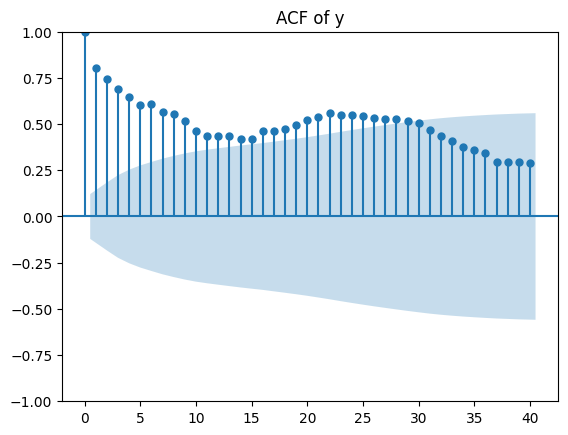

In [10]:
# import acf và pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['y'], lags=40, title='ACF of y');

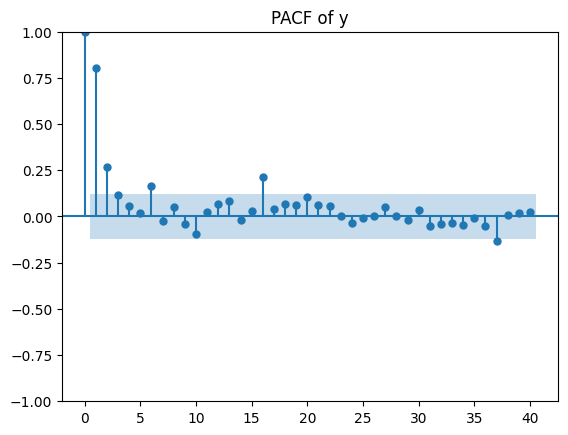

In [11]:
plot_pacf(df['y'], lags=40, title='PACF of y');

### Training and Test

#### GOAL: Predict the next 13 weeks

In [12]:
# Spit the data into training and test
period = 13
train = df[:-period].y
test = df[-period:].y

In [13]:
# Other way to split data
train, test = df.iloc[:-period,0], df.iloc[-period:,0]

### Simple Exponential Smoothing

#### Cách Simple Exponential Smoothing (SES) dự báo - Ví dụ minh họa từng bước
SES dự báo dựa trên công thức:
- Level (L): L_t = α * y_t + (1 - α) * L_{t-1}
- Dự báo cho mọi bước tiếp theo: F_{t+h} = L_t (với h ≥ 1)
Trong đó:
- y_t: giá trị thực tế tại thời điểm t
- L_t: giá trị mức (level) tại thời điểm t
- α: hệ số làm mượt (smoothing level, từ 0 đến 1)
- F_{t+h}: dự báo tại thời điểm t+h
Ví dụ minh họa với 3 tuần đầu tiên:
Giả sử chuỗi y = [y_1, y_2, y_3, ...], α = 0.6, L_0 = y_1 = 1000
- Tuần 1: L_0 = 1000 (khởi tạo bằng giá trị đầu tiên)
- Tuần 2: y_2 = 1200
  L_1 = α * y_2 + (1 - α) * L_0 = 0.6 * 1200 + 0.4 * 1000 = 720 + 400 = 1120
- Tuần 3: y_3 = 900
  L_2 = 0.6 * 900 + 0.4 * 1120 = 540 + 448 = 988
Dự báo tuần 4: F_4 = L_2 = 988
Dự báo tuần 5, 6,... cũng đều bằng L_2 nếu không cập nhật thêm quan sát mới.

In [14]:
ses_model = SimpleExpSmoothing(train).fit()
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                      y   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355478.081
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Tue, 12 Aug 2025
Box-Cox:                        False   Time:                         14:58:49
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5097819                alpha                 True
initial_level              1750.0000                

In [15]:
# Predictions
ses_pred = ses_model.forecast(period)
ses_pred

2022-10-03    3236.663473
2022-10-10    3236.663473
2022-10-17    3236.663473
2022-10-24    3236.663473
2022-10-31    3236.663473
2022-11-07    3236.663473
2022-11-14    3236.663473
2022-11-21    3236.663473
2022-11-28    3236.663473
2022-12-05    3236.663473
2022-12-12    3236.663473
2022-12-19    3236.663473
2022-12-26    3236.663473
Freq: W-MON, dtype: float64

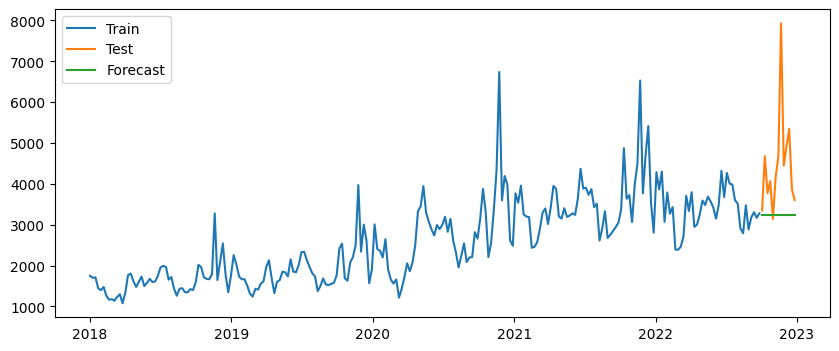

In [16]:
# Set the size of the plot of 10 by 4
plt.figure(figsize=(10, 4))

# Plt the train, test and forecast data
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test')
plt.plot(ses_pred.index, ses_pred.values, label='Forecast')
plt.legend();

### Holt Method (Double Exponential Smoothing)

In [17]:
# Build double exponential smooothing model
model_double = ExponentialSmoothing(
    endog = train,
    trend= "add",
    seasonal= None
).fit()
print(model_double.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74343958.375
Optimized:                         True   AIC                           3135.474
Trend:                         Additive   BIC                           3149.528
Seasonal:                          None   AICC                          3135.823
Seasonal Periods:                  None   Date:                 Tue, 12 Aug 2025
Box-Cox:                          False   Time:                         14:58:50
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093880                alpha                 True
smoothing_trend             0.0000

In [18]:
# Predict with the double ES model
double_pred = model_double.forecast(period)
double_pred

2022-10-03    3248.188426
2022-10-10    3254.078922
2022-10-17    3259.969417
2022-10-24    3265.859912
2022-10-31    3271.750408
2022-11-07    3277.640903
2022-11-14    3283.531399
2022-11-21    3289.421894
2022-11-28    3295.312389
2022-12-05    3301.202885
2022-12-12    3307.093380
2022-12-19    3312.983876
2022-12-26    3318.874371
Freq: W-MON, dtype: float64

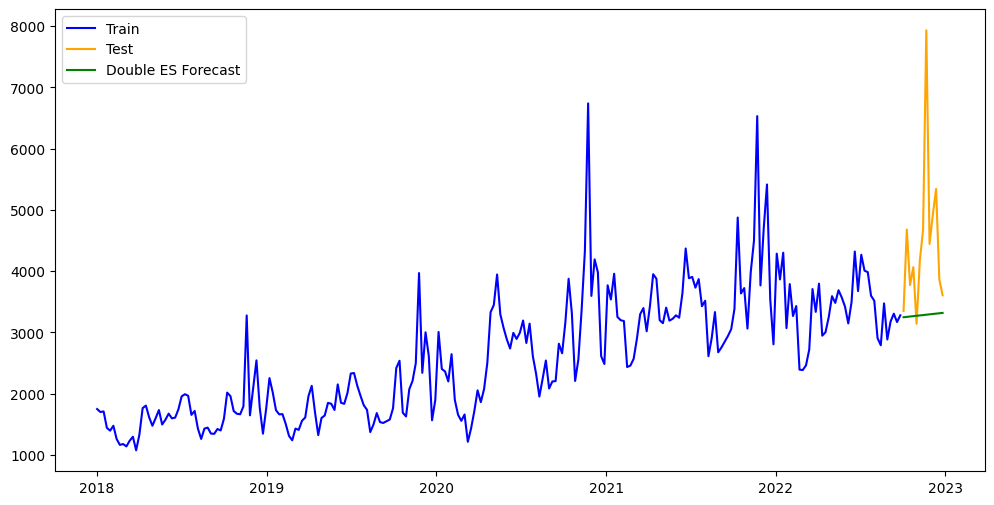

In [19]:
# Plot the train, test and forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(double_pred.index, double_pred, label='Double ES Forecast', color='green')
plt.legend()
plt.show()

### Holt-Winters Method (Triple Exponential Smoothing)

In [20]:
model_triple = ExponentialSmoothing(
    endog=train,
    trend='add',
    seasonal='mul',
    seasonal_periods=52
).fit()
print(model_triple.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                        y   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       21600695.729
Optimized:                         True   AIC                           2932.952
Trend:                         Additive   BIC                           3129.704
Seasonal:                Multiplicative   AICC                          2969.164
Seasonal Periods:                    52   Date:                 Tue, 12 Aug 2025
Box-Cox:                          False   Time:                         14:58:50
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2491438                alpha                 True
smoothing_trend          

In [26]:
# Predict with the Holt-Winters model
holt_pred = model_triple.forecast(steps=13)
holt_pred

2022-10-03    4041.111424
2022-10-10    5040.624784
2022-10-17    3931.859447
2022-10-24    3531.087941
2022-10-31    3441.012595
2022-11-07    4260.019517
2022-11-14    5352.531269
2022-11-21    7237.950721
2022-11-28    4358.900107
2022-12-05    5316.382668
2022-12-12    5271.229643
2022-12-19    3471.734921
2022-12-26    3336.466558
Freq: W-MON, dtype: float64

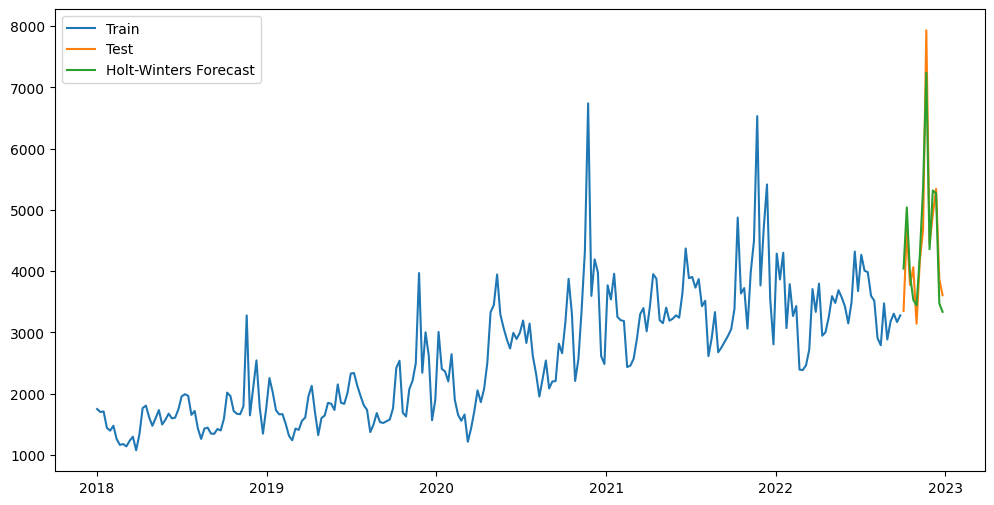

In [27]:
# Plot the train, test and forecast
plt.figure(figsize=(12, 6))

# Plot the train, test and forecast
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters Forecast')
plt.legend()
plt.show()

### Assessing Regression Accuracy

In [28]:
# Calculate and print the RMSE, MAE and MAPE
rmse = root_mean_squared_error(test, holt_pred)
mae = mean_absolute_error(test, holt_pred)
mape = mean_absolute_percentage_error(test, holt_pred)

In [33]:
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {100*mape:.2f}%")

RMSE: 425.49
MAE: 363.71
MAPE: 8.44%


In [34]:
def model_assessment(train, test, predictions, chart_title=None):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(predictions.index, predictions, label='Predictions', color='green')
    plt.title(chart_title)
    plt.legend()
    plt.show()

    # Calculate and print RMSE, MAE, MAPE
    rmse = root_mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = mean_absolute_percentage_error(test, predictions)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {100*mape:.2f}%")

### Daily Data

In [47]:
# Loading the Bitcoin price data
df_daily = pd.read_csv(r"D:\Practice\Machine Learning Project\Forecasting\study-2\course-material\Time Series Analysis\Exponential Smoothing and Holt Winters\bitcoin_price.csv",
                           index_col="Date",
                           parse_dates=True)["Adj Close"].rename("y")

In [48]:
df_daily.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: y, dtype: float64

In [ ]:
# Setting the index frequency to daily
df_daily = df_daily.asfreq('XXXX')
df_daily.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

### Model Assessment

In [51]:
periods = 30
train, test = df_daily[:-periods], df_daily[-periods:]

In [59]:
# Build a holt winter model
model_daily = ExponentialSmoothing(
    endog=train,
    trend='multiplicative',
    seasonal='multiplicative',
    seasonal_periods=365
).fit()

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


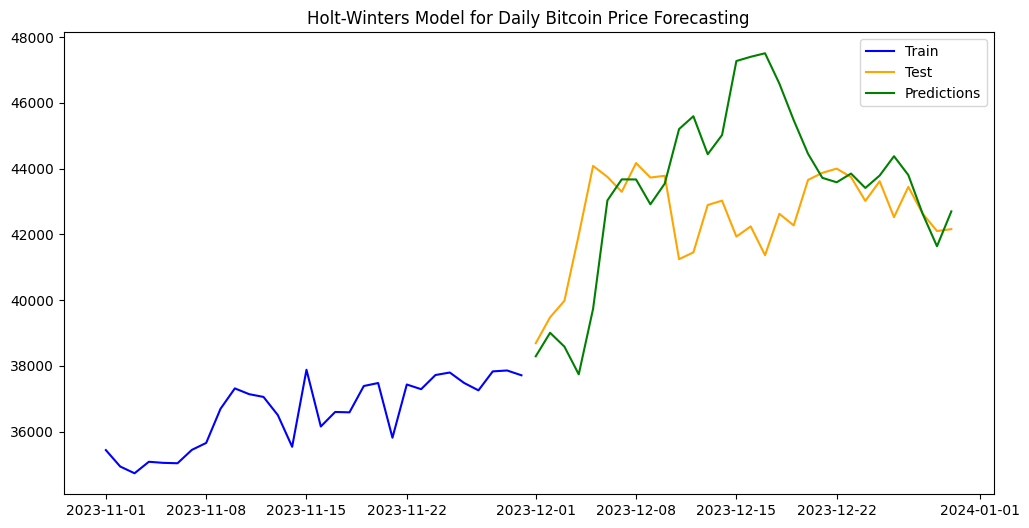

RMSE: 2606.68
MAE: 1806.51
MAPE: 4.28%


In [64]:
# Predict with the Holt Winters
daily_predict = model_daily.forecast(steps=periods)

# Assess the model
model_assessment(train.loc["2023-11"], test, daily_predict, chart_title="Holt-Winters Model for Daily Bitcoin Price Forecasting")
